In [2]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project/bayesian_network/examples/2_brain_damage"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [3]:
from dlroms import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

In [4]:
# Set device and seed

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(0)

In [5]:
# Domain definition

loop = lambda v: np.concatenate((v, v[[0]]))
brain = np.load("brainshape.npz")
domain = fe.polygon(loop(brain["main"][::9])) - fe.polygon(loop(brain["hole1"][::9])) - fe.polygon(loop(brain["hole2"][::8]))

In [6]:
# Meshes and FEM spaces definition

h = 0.02
mesh_H = fe.mesh(domain, stepsize=h)
Vh_H = fe.space(mesh_H, 'CG', 1)
mesh_C = fe.mesh(domain, stepsize=5/2*h)
Vh_C = fe.space(mesh_C, 'CG', 1)
nh_H, nh_C = Vh_H.dim(), Vh_C.dim()
print(nh_H, nh_C)

3378 2315


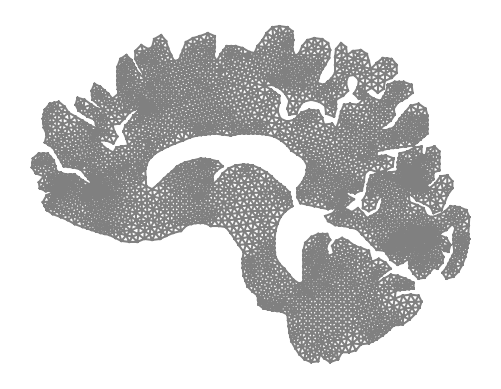

In [7]:
fe.plot(mesh_H)

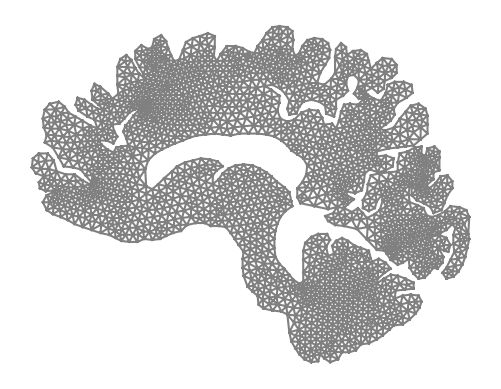

In [8]:
fe.plot(mesh_C)

In [9]:
# Load snapshots for training

data_train = np.load(os.path.join("snapshots", "snapshots_train_H.npz"))
N_train = data_train['mu'].shape[0]
mu_train, u_train = data_train['mu'].astype(np.float32), data_train['u'].astype(np.float32)
mu_train, u_train = torch.tensor(mu_train).to(device), torch.tensor(u_train).to(device)

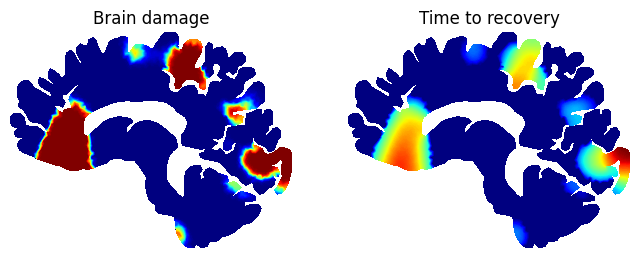

In [10]:
# Print a random training snapshot

which = 4
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_train[which], Vh_H, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_train[which], Vh_H, cmap='jet_r')
plt.subplot(1, 2, 2)
plt.title("Time to recovery")
fe.plot(u_train[which], Vh_H, cmap='jet')

In [11]:
# Load snapshots for testing

data_test = np.load(os.path.join("snapshots", "snapshots_test.npz"))
N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

# High-fidelity model

In [12]:
# DLROM definition

# Initial supports: 0.05, 0.1, 0.05

layer_1 = Geodesic(domain, Vh_H, Vh_C, support=0.05) # default activation: leakyReLU
layer_2 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_3 = Geodesic(domain, Vh_C, Vh_H, support=0.05, activation=None)

In [ ]:
# Train the DLROM with high-fidelity snapshots (with random initialization)

model = DFNN(layer_1, layer_2, layer_3)
model.He()

if device.type == 'cuda':
  model.cuda()
else:
  model.cpu()

model.train(mu_train, u_train, ntrain=N_train, epochs=100, loss=mse(euclidean), verbose=True)

In [ ]:
# Use the model for prediction

model.eval()

with torch.no_grad():
  u_pred_train = model(mu_train)
  u_pred = model(mu_test)

error_train = torch.norm(u_train - u_pred_train, dim=1) / torch.norm(u_train, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print(f"Relative training error: {100 * torch.mean(error_train):.2f}%")
print(f"Relative test error: {100 * torch.mean(error_test):.2f}%")

Relative training error: 7.20%
Relative test error: 9.56%


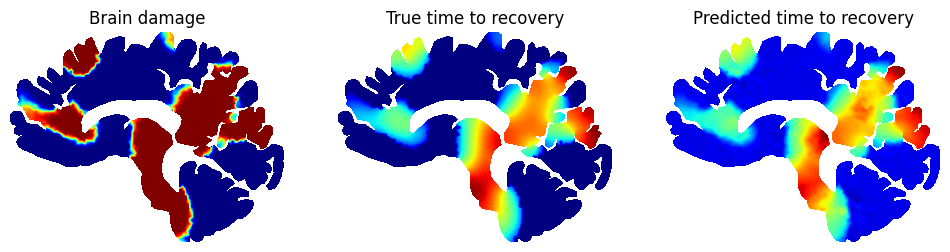

In [ ]:
# Print a random test snapshot against the corresponding prediction

which = 10
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_test[which], Vh_H, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_test[which], Vh_H, cmap='jet_r')
plt.subplot(1, 3, 2)
plt.title("True time to recovery")
fe.plot(u_test[which], Vh_H, cmap='jet')
plt.subplot(1, 3, 3)
plt.title("Predicted time to recovery")
fe.plot(u_pred[which], Vh_H, cmap='jet')

# Bayesian network

In [13]:
import sys
sys.path.append(os.path.join("..", "..", "dlroms"))
from bayesian import *

In [33]:
model = DFNN(layer_1, layer_2, layer_3)
model.He()

if device.type == 'cuda':
  model.cuda()
else:
  model.cpu()

model_bayes = Bayesian(model)
model_bayes.He()

In [34]:
svgd = SVGD(model_bayes, lr=1e-2)

In [35]:
svgd.train(mu_train, u_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

Epoch: 200/200, train: 1.962604, test: 2.126025: 100%|██████████| 200/200 [02:08<00:00,  1.55it/s]


In [36]:
u_pred_bayes_mean, u_pred_bayes_var = model_bayes.predict(mu_test)

In [37]:
error_test_mean = torch.norm(u_test - u_pred_bayes_mean, dim=1) / torch.norm(u_test, dim=1)
print(f"Relative test error (Bayesian): {100 * torch.mean(error_test_mean):.2f}%")

Relative test error (Bayesian): 15.25%


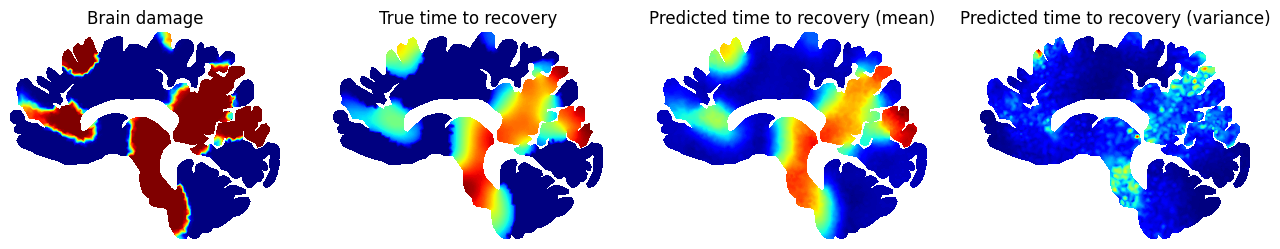

In [38]:
# Print a random test snapshot against the corresponding mean prediction and variance

which = 10
plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_test[which], Vh_H, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_test[which], Vh_H, cmap='jet_r')
plt.subplot(1, 4, 2)
plt.title("True time to recovery")
fe.plot(u_test[which], Vh_H, cmap='jet')
plt.subplot(1, 4, 3)
plt.title("Predicted time to recovery (mean)")
fe.plot(u_pred_bayes_mean[which], Vh_H, cmap='jet')
plt.subplot(1, 4, 4)
plt.title("Predicted time to recovery (variance)")
fe.plot(u_pred_bayes_var[which], Vh_H, cmap='jet')

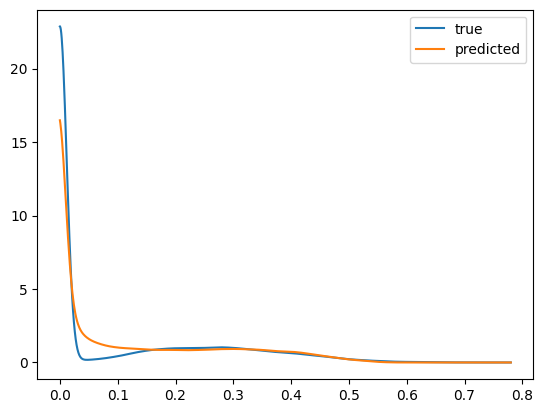

In [40]:
from scipy import stats

u_test_np = u_test.cpu().numpy().flatten()
u_pred_bayes_mean_np = u_pred_bayes_mean.cpu().numpy().flatten()

# Create a KDE estimate
kde_u_test = stats.gaussian_kde(u_test_np)
kde_u_pred_bayes_mean = stats.gaussian_kde(u_pred_bayes_mean_np)

x = np.linspace(u_test_np.min(), u_test_np.max(), 1000)
plt.plot(x, kde_u_test(x), label='true')
plt.plot(x, kde_u_pred_bayes_mean(x), label='predicted')
plt.legend()
plt.show()

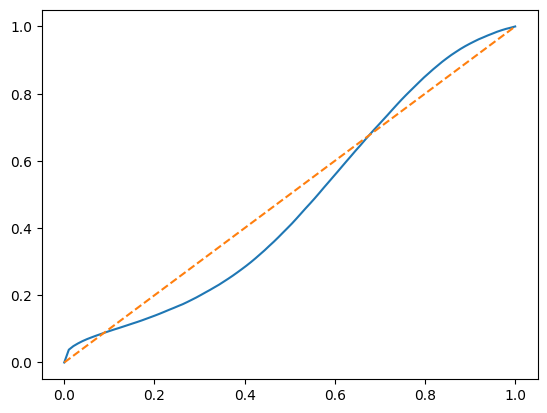

In [42]:
from scipy.stats import norm

u_test_np = u_test.cpu().numpy().flatten()
u_pred_bayes_mean_np = u_pred_bayes_mean.cpu().numpy().flatten()
u_pred_bayes_var_np = u_pred_bayes_var.cpu().numpy().flatten()

quantiles = np.linspace(0, 1, 100)

calibration_curve = np.zeros_like(quantiles)

for i in range(len(u_test_np)):
	normal_quantiles = norm.ppf(quantiles, loc=u_pred_bayes_mean_np[i], scale=np.sqrt(u_pred_bayes_var_np[i]))
	mask = (normal_quantiles > u_test_np[i])
	calibration_curve += mask

calibration_curve /= len(u_test_np)

plt.plot(quantiles, calibration_curve)
plt.plot(quantiles, quantiles, '--')
plt.show()